### n(E) == n(D). Training a vanilla DC-GAN

In [1]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels, checkAndCreateFolder
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

from numpy import save as np_save
from numpy import load as np_load

import PIL.Image
from cStringIO import StringIO
from os import fsync

import imageio

In [2]:
def sync(fh):
    """
    This makes sure data is written to disk, so that buffering doesn't influence the timings.
    """
    fh.flush()
    fsync(fh.fileno())

In [3]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')
    
    return plt
    #plt.show()

In [4]:
numInputChannels = 100
numGenFilter = 64
numDiscFilter = 64
numOutputChannels = 1


learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

numOfSamples = 1000

In [5]:
# load only from a single class for now

classes = [0]
instances = [7000 for i in range(10)]
batchSize = 256

mnist_dataset = loadDataset('MNIST', classes, instances, 'train')
mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

svhn_dataset = loadDataset('SVHN', classes, instances, 'train')
svhn_dataloader = torch.utils.data.DataLoader(svhn_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

In [6]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numDiscFilter)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numInputChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    
    imageList = []
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            #print discRealInput.shape
            discRealOutput = D(discRealInputV)
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        # create an image for every epoch
        # generate samples from trained generator
        genImage = G(fixedNoiseV)
        genImage = genImage.data
        genImage = genImage.cpu()[:100,:,:,:]

        genImage = torchvision.utils.make_grid(genImage, nrow=10)
        genImage = (genImage/2) + 0.5
        genImage = genImage.permute(1,2,0)
        genImage = genImage.numpy() 
        
        plt.figure()
        fig = plt.figure(figsize=(20,10))
        plt.imshow(genImage)
        plt.axis('off')

        txt = 'Epoch: '+ str(epoch+1)
        fig.text(.45,.05,txt)
        
        plt.savefig('y.png', bbox_inches='tight')
        imageList.append(imageio.imread('y.png'))
        plt.close('all')

    # create animation
    animFolderName = './animation'+'/'
    checkAndCreateFolder(animFolderName)
    animFileName = animFolderName+'Experiment2'+'.gif'

    imageio.mimsave(animFileName, imageList, fps=5)
    
    
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()[:100,:,:,:]

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    plt.close()
    
    
    # training plot
    x = showTrainHist(trainHist)
    lossFolderName = './loss'+'/'
    checkAndCreateFolder(lossFolderName)
    lossFileName = lossFolderName+'Experiment2'+'.png'
    plt.savefig(lossFileName, bbox_inches='tight')
    plt.close()
    
    
    # saving generator and discriminator models
    modelFolderName = './models'+'/'
    checkAndCreateFolder(modelFolderName)
    generatorFileName = modelFolderName+'Experiment2_G'+'.pt'
    discriminatorFileName = modelFolderName+'Experiment2_D'+'.pt'
    torch.save(G.state_dict(), generatorFileName)
    torch.save(D.state_dict(), discriminatorFileName)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/30] time: 5.04, loss_d: 0.334, loss_g: 4.554
Epoch : [2/30] time: 4.66, loss_d: 0.275, loss_g: 6.277
Epoch : [3/30] time: 4.66, loss_d: 0.526, loss_g: 4.653
Epoch : [4/30] time: 4.67, loss_d: 0.503, loss_g: 3.390
Epoch : [5/30] time: 4.70, loss_d: 0.418, loss_g: 2.877
Epoch : [6/30] time: 4.78, loss_d: 0.214, loss_g: 3.014
Epoch : [7/30] time: 5.05, loss_d: 0.170, loss_g: 3.206
Epoch : [8/30] time: 5.08, loss_d: 1.114, loss_g: 3.046
Epoch : [9/30] time: 5.05, loss_d: 0.253, loss_g: 2.611
Epoch : [10/30] time: 5.04, loss_d: 0.848, loss_g: 2.894
Epoch : [11/30] time: 5.08, loss_d: 0.896, loss_g: 1.861
Epoch : [12/30] time: 5.21, loss_d: 0.417, loss_g: 2.232
Epoch : [13/30] time: 5.03, loss_d: 0.286, loss_g: 2.461
Epoch : [14/30] time: 5.06, loss_d: 1.260, loss_g: 1.705
Epoch : [15/30] time: 5.05, loss_d: 0.841, loss_g: 1.643
Epoch : [16/30] time: 5.05, loss_d: 0.795, loss_g: 1.712
Epoch : [17/30] time: 5.04, loss_d: 0.941, loss_g: 1.971
Epoch : [18/30] time: 5.04, loss_d: 0.82

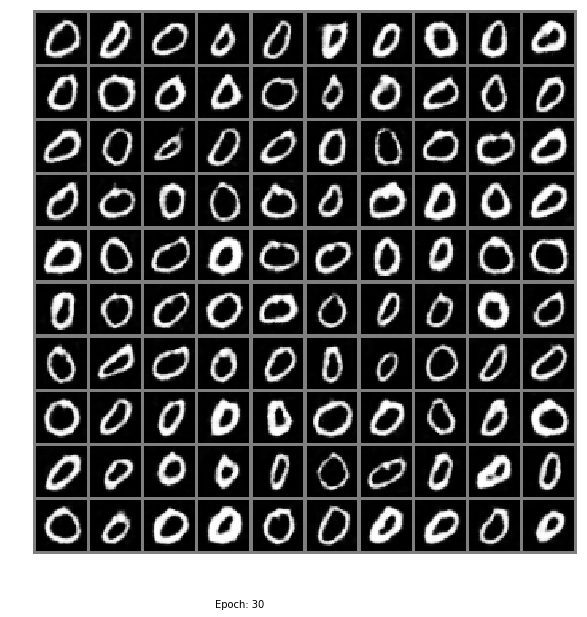

In [7]:
from model import Generator, Discriminator

train(mnist_dataloader, epochs=30)

In [8]:
def test():
    '''
    Inputs :

    dataSets : List : Datasets for which samples are to be genrated
    instances : List : Number of instances to be used from original dataset
    classes : List : Classes for which samples are to be generated

    Output :

    File with 1000 compressed images generated by GAN

    '''

    modelFolder = 'models'+'/'
    modelFile = modelFolder+'Experiment2_G'+'.pt'    


    # load the model leannt during training
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    G.load_state_dict(torch.load(modelFile))

    genImageConcat = np.empty(1)
    for sample in range(numOfSamples):
        noise = torch.FloatTensor(1,
                                  numInputChannels,
                                  1,
                                  1)
        noise.normal_(0,1)

        if cuda:
            G = G.cuda()
            noise = noise.cuda()
        noiseVariable = Variable(noise)

        genImage = G(noiseVariable)
        genImage = genImage.data
        genImage = genImage.cpu()
        genImage = genImage.numpy()

        maxImage = np.max(genImage)
        minImage = np.min(genImage)
        #print maxImage, minImage

        genImage = np.multiply(np.divide((genImage-minImage),(maxImage-minImage)),255.0)
        maxImage = np.max(genImage)
        minImage = np.min(genImage)

        if sample==0:
            genImageConcat = genImage
        elif sample>=1:
            genImageConcat = np.concatenate((genImageConcat, genImage),
                                            axis=0)
    testFolderName = './test'+'/'
    checkAndCreateFolder(testFolderName)

    testFileName = testFolderName+'Experiment2.npy'

    # save the image in some format
    with open(testFileName,'wb+') as fh:
        genImageConcat = np.squeeze(genImageConcat)
        np_save(fh, genImageConcat, allow_pickle=False)
        sync(fh)


In [9]:
test()

In [10]:
def showImageMatrix():
    '''
    Inputs :
    
    dataSets : List : Datasets for which samples are to be genrated
    instances : List : Number of instances to be used from original dataset
    classes : List : Classes for which samples are to be generated
    
    Outputs :
    
    5x5 image matrix 
    
    '''
    testFolderName = './test'+'/'
    testFileName = testFolderName+'Experiment2'+'.npy'
    images = np_load(testFileName)
    
    # get random list of images to be displayed
    randomList = np.random.randint(0,1000,(25))
    imageList = images[randomList]
    
    
    fmt = 'png'
    
    # need to generalise this snippet
    fig, axes = plt.subplots(5,5)
    fig.tight_layout()
    fig.subplots_adjust(wspace=-0.7, hspace=-0.1)
    plt.axis('off')
    
    for i in range(5):
        for j in range(5):
            f = StringIO()
            image = PIL.Image.fromarray(np.uint8(imageList[i*5+j]))
            image.save(f,fmt)
            axes[i,j].imshow(image, cmap='Greys_r')
            axes[i,j].axis('off')
            axes[i,j].set_xticklabels([])
            axes[i,j].set_yticklabels([])
            axes[i,j].set_aspect("equal")
    
    resultFolderName = './results'+'/'
    checkAndCreateFolder(resultFolderName)
    resultFileName = resultFolderName+'/'+'Experiment2'+'.png'
    plt.savefig(resultFileName, bbox_inches='tight')
    plt.show()
    plt.close()

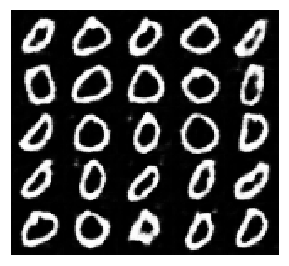

In [11]:
showImageMatrix()